In [1]:
import os
import pickle
import glob
import gzip
from tqdm.notebook import tqdm #from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import defusedxml.ElementTree as ET
from collections import OrderedDict
import collections
from collections import Counter
import datetime


In [2]:
path_1= '/home/admin_user/デスクトップ/folder_05'
os.chdir(path_1)
os.getcwd()
#print(len(csv_list), csv_list)

'/home/admin_user/デスクトップ/folder_05'

In [3]:
#読み込み
each_ds_pair= pd.read_csv('each_ds_pair.csv', engine='python')

In [4]:
#共起ペアと共起数
co_occ_pair = pd.DataFrame(each_ds_pair.groupby(['symptom', 'disease']).size()).reset_index()
co_occ_pair = co_occ_pair.rename(columns={0:'co_occurrence'})
co_occ_pair = co_occ_pair.sort_values(by = "co_occurrence", ascending=False).reset_index(drop=True)
print(len(co_occ_pair))

211838


In [22]:
co_occ_pair[:3]

,symptom,disease,co_occurrence
0,Obesity,Obesity,256398
1,Seizures,Seizures,65543
2,Intellectual Disability,Intellectual Disability,52289


<ipython-input-24-928ddf1ab9b8>:11: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)
<ipython-input-24-928ddf1ab9b8>:11: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)


ポイントの数は共起頻度数の種類数 1300


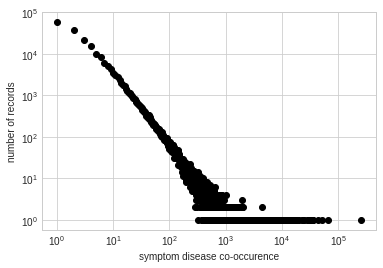

In [24]:
#一文献につき共起する数とその文献数

#両方の軸を対数スケールで設定する必要がある　loglog() 関数を使用
#loglog() 関数
#X 軸と Y 軸の両方に沿って対数スケーリングを行う時使える
#X 軸と Y 軸の対数の底は、basex パラメータと basey パラメータによって設定

a = pd.Series(co_occ_pair["co_occurrence"].value_counts())

plt.scatter(a.index, a, color="black")
plt.loglog(basex=10,basey=10)
plt.xlabel("symptom disease co-occurence")
plt.ylabel("number of records",)
print("ポイントの数は共起頻度数の種類数", len(a))
plt.show()

In [5]:
#save to csv
os.chdir(path_1)
co_occ_pair.to_csv("co_occ_pair.csv", index=False)

In [6]:
# for chi2
chi2_pair = co_occ_pair[["symptom","disease"]].values.tolist()
len(chi2_pair)

211838

In [7]:
crosstab_df = pd.crosstab(each_ds_pair["symptom"], each_ds_pair["disease"], margins=True, margins_name="Total")
crosstab_df.tail()

disease,22q11 Deletion Syndrome,"46, XX Disorders of Sex Development","46, XX Testicular Disorders of Sex Development","ACTH Syndrome, Ectopic",ACTH-Secreting Pituitary Adenoma,"AIDS Arteritis, Central Nervous System",AIDS Dementia Complex,AIDS-Associated Nephropathy,AIDS-Related Complex,AIDS-Related Opportunistic Infections,...,alpha-Mannosidosis,alpha-Thalassemia,beta-Mannosidosis,beta-Thalassemia,von Hippel-Lindau Disease,"von Willebrand Disease, Type 1","von Willebrand Disease, Type 2","von Willebrand Disease, Type 3",von Willebrand Diseases,Total
symptom,,,,,,,,,,,,,,,,,,,,,
"Vomiting, Anticipatory",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,290
Waterhouse-Friderichsen Syndrome,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1009
Weight Gain,0,0,0,2,1,0,0,0,2,5,...,0,0,0,0,0,0,0,0,1,26211
Weight Loss,0,0,0,2,0,0,1,2,2,51,...,0,0,0,0,4,0,0,0,0,50094
Total,75,73,2,39,25,4,421,182,103,1850,...,63,361,19,495,160,1,19,10,293,5632191


In [8]:
from scipy.stats import chi2

all_num = crosstab_df.loc["Total","Total"]

chi2_list=[] 
for pair in tqdm(chi2_pair[:]):
    #print(pair)
        
        #観測度数　()内は期待度数
        #------------------------------------------
        #disease         Obesity         not_Obesity         All
        #symptom                                  
        #Obesity         observed_1(expected_1)     observed_2(expected_2)       target_symptom_num
        #not_Obesity     observed_3(expected_3)     observed_4(expected_4)       (all_num - target_symptom_num)
        #All             target_disease_num        (all_num - target_disease_num)        all_num
        
        
        #例
        
        #観測度数
        #disease      Obesity  not_Obesity     All
        #symptom                                  
        #Obesity         5458         7965   13423
        #not_Obesity     2368       112517  114885
        #All             7826       120482  128308
        
        #期待度数: [
        #    [   818.72056302  12604.27943698  13423.        ]
        #    [  7007.27943698 107877.72056302 114885.        ]
        #    [  7826.         120482.         128308.        ]]
        
        
    #観測度数 observed
    observed_1 = crosstab_df.loc[pair[0], pair[1]]
    target_symptom_num = crosstab_df.loc[pair[0], "Total"]
    target_disease_num = crosstab_df.loc["Total", pair[1]]
    #以下all_numは計算済み
    observed_2 = target_symptom_num - observed_1
    observed_3 = target_disease_num- observed_1
    observed_4 = all_num - (observed_1 + observed_2 + observed_3)
        
    #期待度数 expected
    expected_1 = target_symptom_num / all_num * target_disease_num 
    expected_2 = target_symptom_num / all_num * (all_num - target_disease_num)
    expected_3 = (all_num - target_symptom_num) / all_num * target_disease_num 
    expected_4 = (all_num - target_symptom_num) / all_num * (all_num - target_disease_num)
        
    #print(observed_1, observed_2, observed_3, observed_4) #観測度数
    #print(expected_1, expected_2, expected_3, expected_4) #期待度数
        
    #計算
    #χ2 = （【観測度数-期待度数】の二乗）÷期待度数　の総和
    chai_value = (((observed_1 - expected_1)**2)/expected_1) + (((observed_2 - expected_2)**2)/expected_2) + (((observed_3 - expected_3)**2)/expected_3) + (((observed_4 - expected_4)**2)/expected_4)
    #p値
    p_value = chi2.sf(chai_value, df=1) #1-sp.stats.chi2.cdf(x = chai_value ,df = 1)
        
    chi2_list.append([pair[0], pair[-1], chai_value, p_value ])
chi2_df = pd.DataFrame(chi2_list)

  0%|          | 0/211838 [00:00<?, ?it/s]

In [9]:
chi2_df = chi2_df.sort_values(by=[0,1]).reset_index(drop=True)
chi2_df.head()

,0,1,2,3
0,"Abdomen, Acute","46, XX Disorders of Sex Development",2.454944,0.117155
1,"Abdomen, Acute",AIDS-Related Opportunistic Infections,2.639858,0.104213
2,"Abdomen, Acute",Abdominal Abscess,2601.302103,0.000000
3,"Abdomen, Acute",Abdominal Injuries,16087.394838,0.000000
4,"Abdomen, Acute",Abdominal Neoplasms,1997.817541,0.000000


In [10]:
#chi2_df整形
chi2_df = chi2_df.reset_index(drop=True)
chi2_df.columns=["symptom", "disease", "chi2", "p"]
chi2_df["1-p"] = 1-chi2_df["p"]
chi2_df = chi2_df.sort_values(by="1-p", ascending=True).reset_index(drop=True)
chi2_df["Np"] = chi2_df.index

In [11]:
#p値でカットオフ

#95％のところにあるp値
import numpy as np

num = np.percentile(np.array(chi2_df["p"]), 95) 
print(num)
#その値に最も近いp値のインデックスを取得
index = np.abs(chi2_df["p"] - num).argsort()[0].tolist()

#５％のところにある1-pでも同じ
#index = np.abs(chi2_df["1-p"] -np.percentile(np.array(chi2_df["1-p"]), 5)).argsort()[0].tolist()

print("index number: ", index)
chi2_df[index:index+1]

0.8485460851230835
index number:  10592


,symptom,disease,chi2,p,1-p,Np
10592,Overweight,Varicocele,0.036471,0.848546,0.151454,10592


In [12]:
#プロット

def calc_slope_intersept(x1, y1, x2, y2):
    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    return (a, b)

#座標の最小値と最大値を設定
x1 = 0
y1 = 0
x2 = chi2_df.loc[index, "1-p"]
y2 = chi2_df.loc[index, "Np"]
print(x1, y1, "→", x2, y2)

if __name__ == "__main__":
    a, b = calc_slope_intersept(x1, y1, x2, y2)

0 0 → 0.1514539148769165 10592


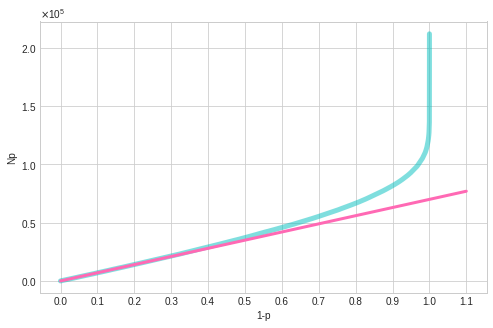

In [13]:
import sqlalchemy
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(8,5))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(1,1,1)
ax.set_xticks([i/10 for i in range(0,12,1)])
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#ax.set_title("")
ax.set_xlabel('1-p')
ax.set_ylabel('Np')

#曲線
x2 = chi2_df["1-p"]
y2 = chi2_df["Np"]
plt.plot(x2, y2, linewidth=5, color="c", alpha=0.5)

#(0,0)と最大値の2点を直線で結ぶ
plt.plot([0, 1.1], [0, a*1.1],  linewidth=3, color="hotpink", alpha=1)
plt.grid(True)
plt.show()

In [14]:
chi2_df[chi2_df.duplicated()] #重複行は無し

,symptom,disease,chi2,p,1-p,Np


In [15]:
#共起ペアを減らす準備（P値は0.05未満のもののみを抽出）

In [16]:
len(chi2_df[chi2_df["p"]<0.05]), len(chi2_df[:10592])

(118834, 10592)

In [17]:
#0.05で切った共起ぺアに共起数を追加

#χ二乗検定のp値0.05未満のデータと co_occ_pair をマージ、共通のデータだけにする
cutoff_pair = chi2_df[chi2_df["p"]<0.05].merge(co_occ_pair, on=["symptom", "disease"])
#共起数でソート
cutoff_pair = cutoff_pair.sort_values(by='co_occurrence', ascending=False).reset_index(drop=True)

In [18]:
cutoff_pair.to_csv("cutoff_pair.csv", index=False)

In [19]:
#カットオフ前後比較

In [20]:
print("カットオフ前")
print("共起数:", co_occ_pair["co_occurrence"].sum())
print("共起ペアの件数:", len(co_occ_pair))
print("疾患タームの数:", co_occ_pair["disease"].nunique())
print("症状タームの数:", co_occ_pair["symptom"].nunique())

カットオフ前
共起数: 5632191
共起ペアの件数: 211838
疾患タームの数: 4716
症状タームの数: 384


In [21]:
print("カットオフ後")
print("共起数:", cutoff_pair["co_occurrence"].sum())
print("共起ペアの件数:", len(cutoff_pair))
print("疾患タームの数:", cutoff_pair["disease"].nunique())
print("症状タームの数:", cutoff_pair["symptom"].nunique())

カットオフ後
共起数: 5234673
共起ペアの件数: 118834
疾患タームの数: 4716
症状タームの数: 384
